#Problem Statement

*   Buatlah model menggunakan Convolutional Neural Network untuk membuat klasifikasi dari data image yang diberikan. Label dari data tersebut sesuai dengan nama folder-nya (ada 2 label: “NORMAL” dan “COVID”). Data ini berisi gambar rontgen paru-paru normal dan yang terindikasi covid.
*   Bebas menggunakan arsitektur CNN apapun (AlexNet, VGG Net, ResNet, dll).
*   Gunakan metric classification (accuracy, recall, precision, f1-score, dsb) untuk menunjukkan performa model yang telah kalian buat. Bisa dibantu dengan modul classification_report pada library sklearn.
*   Tidak ada minimum nilai accuracy yang harus dicapai untuk pengerjaan tugas ini. Silahkan preprocessing, tunning parameter, dan pengaturan model lainnya sesuai kreatifitas masing-masing.




#About Dataset

*  NORMAL : data image rontgen paru-paru normal
*  COVID : data image rontgen paru-paru terkena COVID


#Importing Libraries

In [ ]:
!pip install split-folders

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import splitfolders
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#EDA

##Displaying Sample Images

In [ ]:
levels = ['Normal', 'COVID']
path = '/content/drive/MyDrive/Celerates/dataset/'

image dimensions: (256, 256)


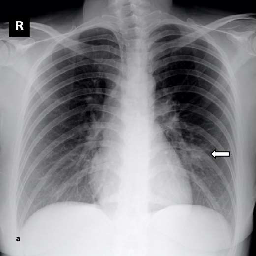

In [ ]:
# Getting sample covid image
covid_image_path = '/content/drive/MyDrive/Celerates/dataset/COVID/COVID_2.png'
covid_image = Image.open(covid_image_path)
print("image dimensions:", covid_image.size)
covid_image

image dimensions: (232, 232)


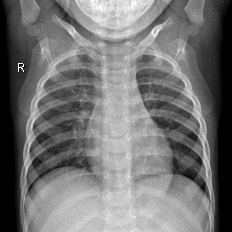

In [ ]:
# Getting sample normal image
normal_image_path = '/content/drive/MyDrive/Celerates/dataset/NORMAL/NORMAL_40.png'
normal_image = Image.open(normal_image_path)
print("image dimensions:", normal_image.size)
normal_image

##Getting dimensions of all images to check if there are any anomalies in the images data as well as to know the range of shapes and colors

In [ ]:
input_folder = '/content/drive/MyDrive/Celerates/dataset'
output_folder = '/content/drive/MyDrive/Celerates/roentgen'
if os.path.exists(input_folder):
    print("Input folder exists.")
else:
    print("Input folder does not exist.")

Input folder exists.


In [ ]:
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.6, 0.2, 0.2))

Copying files: 3429 files [26:10,  2.18 files/s]


In [ ]:
train_dir = os.path.join(output_folder, 'train')
val_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')

print("Dataset successfully split!")

Dataset successfully split!


In [ ]:
from itertools import chain
from PIL import Image

# Menginisialisasi set untuk menyimpan dimensi dan mode unik
unique_dimensions = set()
unique_modes = set()

# Fungsi untuk memproses subdirektori
def process_subdir(subdir_path):
    for filename in os.listdir(subdir_path):
        file_path = os.path.join(subdir_path, filename)
        image = Image.open(file_path)
        unique_dimensions.add(image.size)
        unique_modes.add(image.mode)

# Memproses subdirektori dalam train, val, dan test
for subdir in os.listdir(train_dir):
    process_subdir(os.path.join(train_dir, subdir))

for subdir in os.listdir(val_dir):
    process_subdir(os.path.join(val_dir, subdir))

for subdir in os.listdir(test_dir):
    process_subdir(os.path.join(test_dir, subdir))

print("Unique modes:", unique_modes)
print("Unique dimensions:", unique_dimensions)


Unique modes: {'RGBA', 'RGB'}
Unique dimensions: {(256, 256), (232, 232)}


##All image are at different sizes they will have to be resized into same dimension later

In [ ]:
#Setting the dimensions for images to be resized to
DIMENSIONS = [256, 256]

In [ ]:
#Getting image samples in certain unique color mode
displayed_images = set()
for subdir in chain(os.listdir(train_dir), os.listdir(test_dir)):
    subdir_path = os.path.join(train_dir, subdir) if subdir in os.listdir(train_dir) else os.path.join(test_dir, subdir)
    for filename in os.listdir(subdir_path):
        file_path = os.path.join(subdir_path, filename)
        image = Image.open(file_path)

        if image.mode == "RGBA" and file_path not in displayed_images:
            plt.axis("off")
            plt.imshow(image)
            plt.show()
            displayed_images.add(file_path)

##Data Augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=50,
      width_shift_range=0.25,
      height_shift_range=0.25,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True,
      brightness_range=(0.8, 1.2),
      fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=tuple(DIMENSIONS),
        class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
        val_dir,
        target_size=tuple(DIMENSIONS),
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=tuple(DIMENSIONS),
        class_mode='binary',
        shuffle=False)

Found 2057 images belonging to 2 classes.
Found 685 images belonging to 2 classes.
Found 687 images belonging to 2 classes.


#CNN Model

##CNN With 1 Convolutional Layer

###Create CNN Model

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend

In [ ]:
def onelayercnn():
    backend.clear_session()
    cnn1 = Sequential()
    cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(*DIMENSIONS, 3)))
    cnn1.add(MaxPooling2D(pool_size=(2, 2)))
    cnn1.add(Dropout(0.2))
    cnn1.add(Flatten())
    cnn1.add(Dense(128, activation='relu'))
    cnn1.add(Dense(1, activation='sigmoid'))
    cnn1.summary()
    return cnn1

In [ ]:
cnn1 = onelayercnn()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 flatten (Flatten)           (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 128)               66064512  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [ ]:
cnn1.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

###Training Model

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10
history = cnn1.fit(
      train_generator,
      validation_data=valid_generator,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)

Epoch 1/10
65/65 [==============================] - 300s 5s/step - loss: 3.9263 - accuracy: 0.6913 - val_loss: 0.3088 - val_accuracy: 0.8861
Epoch 2/10
65/65 [==============================] - 299s 5s/step - loss: 0.3262 - accuracy: 0.8658 - val_loss: 0.3046 - val_accuracy: 0.8672
Epoch 3/10
65/65 [==============================] - 300s 5s/step - loss: 0.3303 - accuracy: 0.8663 - val_loss: 0.2782 - val_accuracy: 0.8759
Epoch 4/10
65/65 [==============================] - 317s 5s/step - loss: 0.3125 - accuracy: 0.8712 - val_loss: 0.2336 - val_accuracy: 0.9153
Epoch 5/10
65/65 [==============================] - 308s 5s/step - loss: 0.2871 - accuracy: 0.8916 - val_loss: 0.2079 - val_accuracy: 0.9255
Epoch 6/10
65/65 [==============================] - 320s 5s/step - loss: 0.2970 - accuracy: 0.8789 - val_loss: 0.2430 - val_accuracy: 0.8993
Epoch 7/10
65/65 [==============================] - 309s 5s/step - loss: 0.2911 - accuracy: 0.8760 - val_loss: 0.3954 - val_accuracy: 0.8321
Epoch 8/10
65

In [ ]:
score1 = cnn1.evaluate(test_generator, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 0.6430136561393738
Test accuracy: 0.7074235677719116


My accuracy is 70%

###Plot training and validation loss

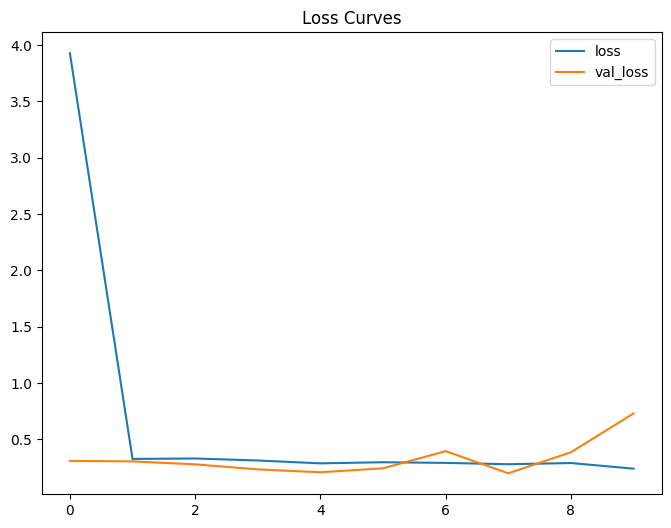

In [ ]:
plt.figure(figsize=(8,6))
plt.title("Loss Curves")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

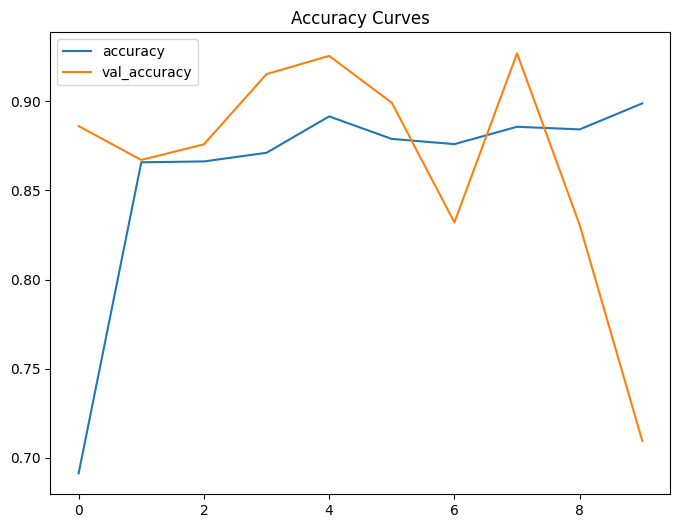

In [ ]:
plt.figure(figsize=(8,6))
plt.title("Accuracy Curves")
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

###Classification Report

In [ ]:
y_pred = cnn1.predict(test_generator)
y_pred[:10]

22/22 [==============================] - 20s 866ms/step


array([[0.13570854],
       [0.98227197],
       [0.37403366],
       [0.93528336],
       [0.9827744 ],
       [0.19943812],
       [0.54145044],
       [0.41236195],
       [0.30204365],
       [0.8733518 ]], dtype=float32)

In [ ]:
y_true = test_generator.labels
y_pred = np.round(y_pred)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.38      0.55       326
           1       0.64      1.00      0.78       361

    accuracy                           0.71       687
   macro avg       0.82      0.69      0.67       687
weighted avg       0.81      0.71      0.67       687



In [ ]:
incorrect_indices = np.where(y_true.reshape(-1,1) != y_pred)[0]
correct_indices = np.where(y_true.reshape(-1,1) == y_pred)[0]

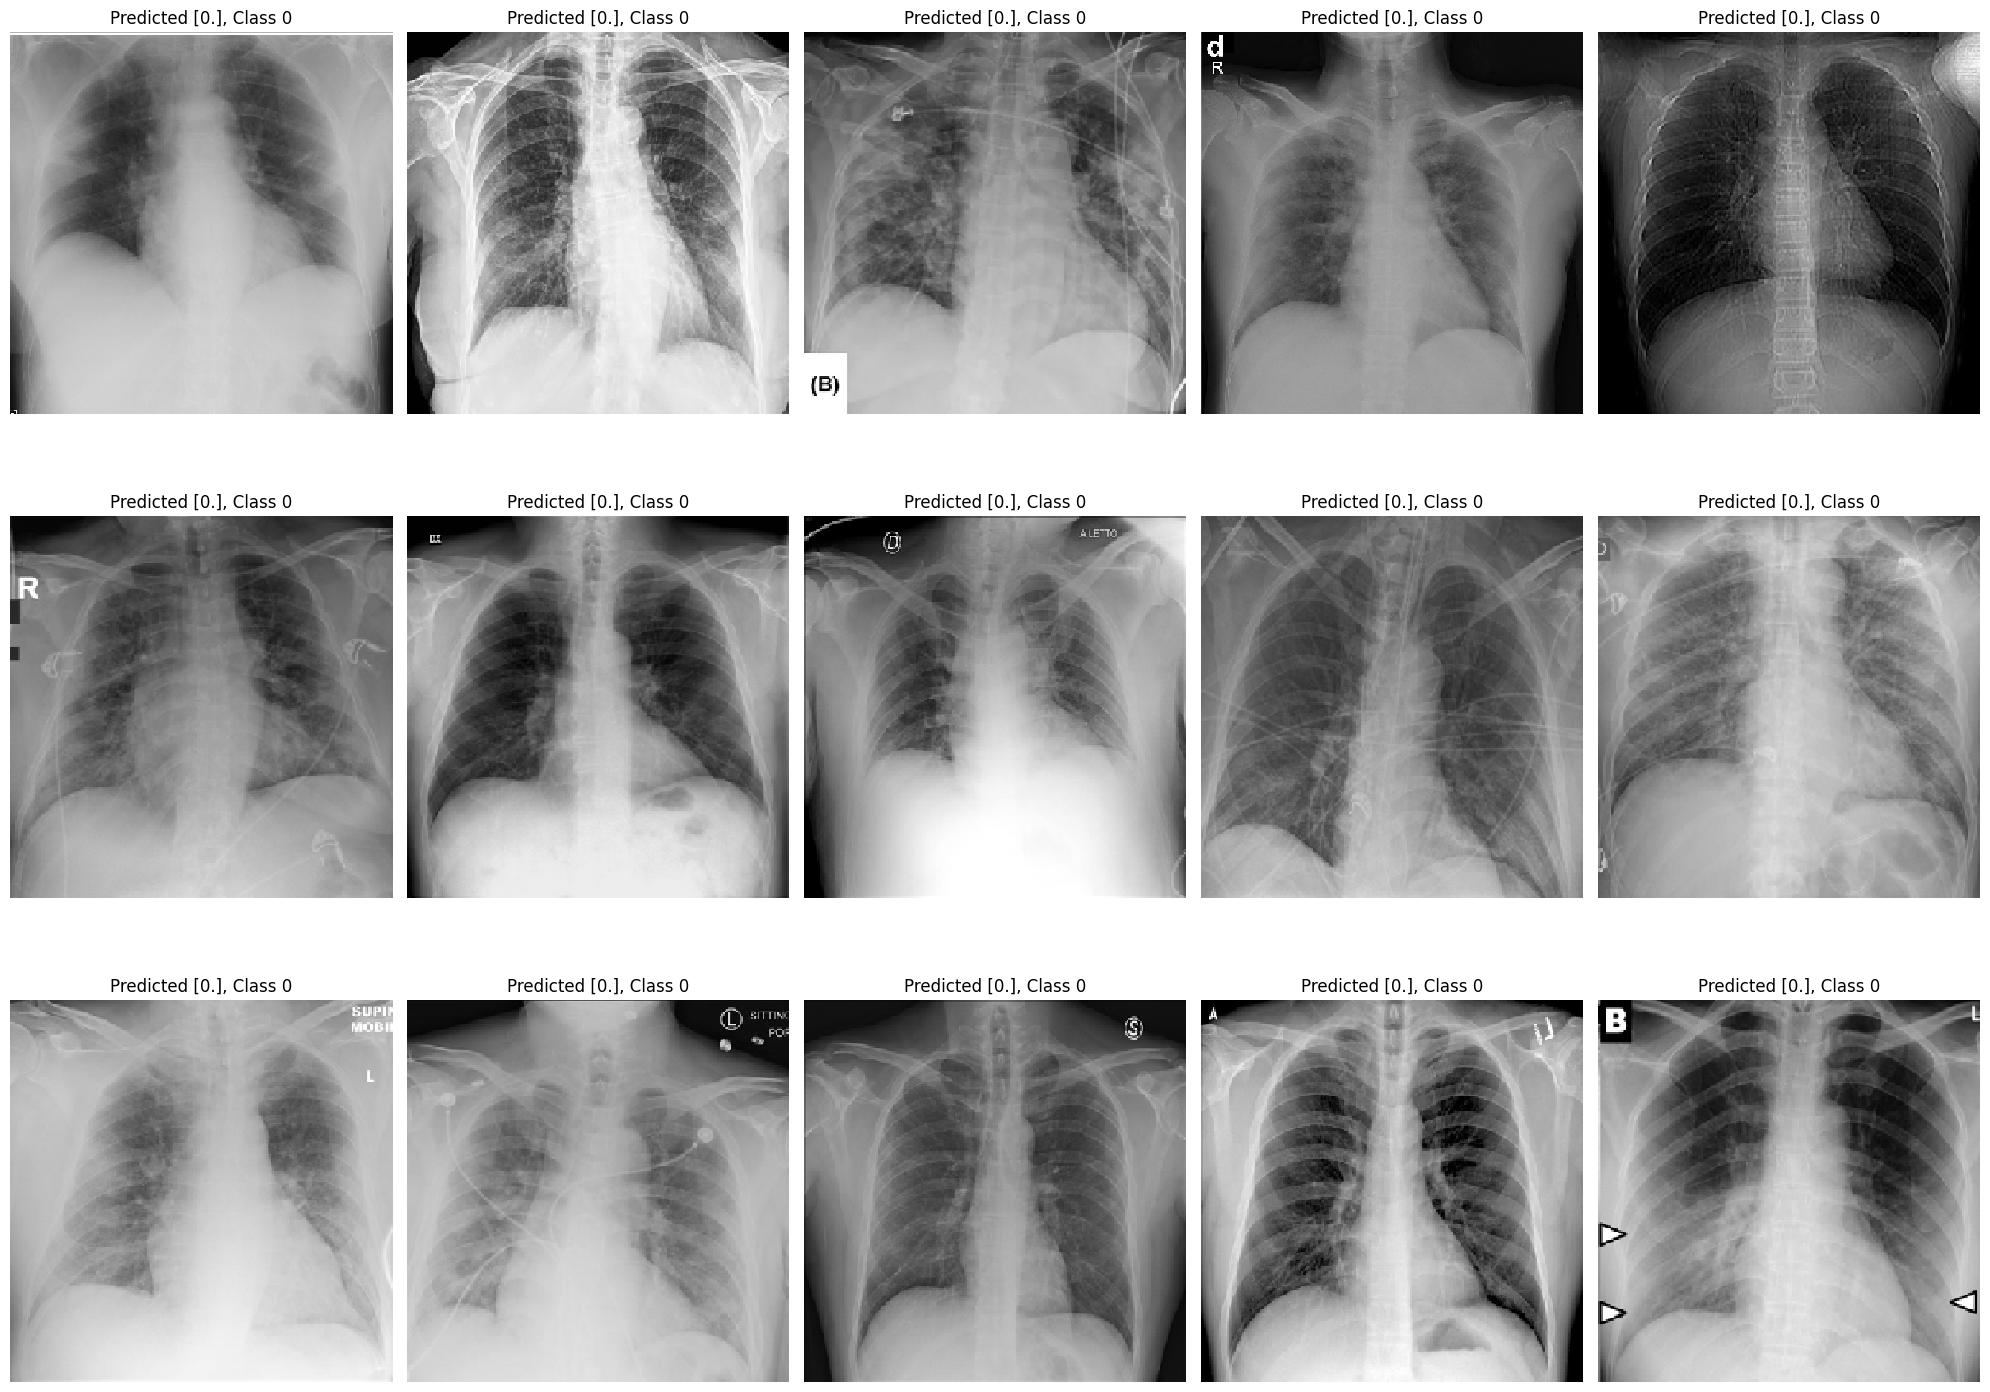

In [ ]:
plt.figure(figsize=(20, 20))
for i, correct in enumerate(correct_indices[:15]):
    image_path = test_generator.filepaths[i]
    image = plt.imread(image_path)
    plt.subplot(4, 5, i+1)
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_pred[correct], y_true[correct]))
    plt.axis("off")
    plt.tight_layout()

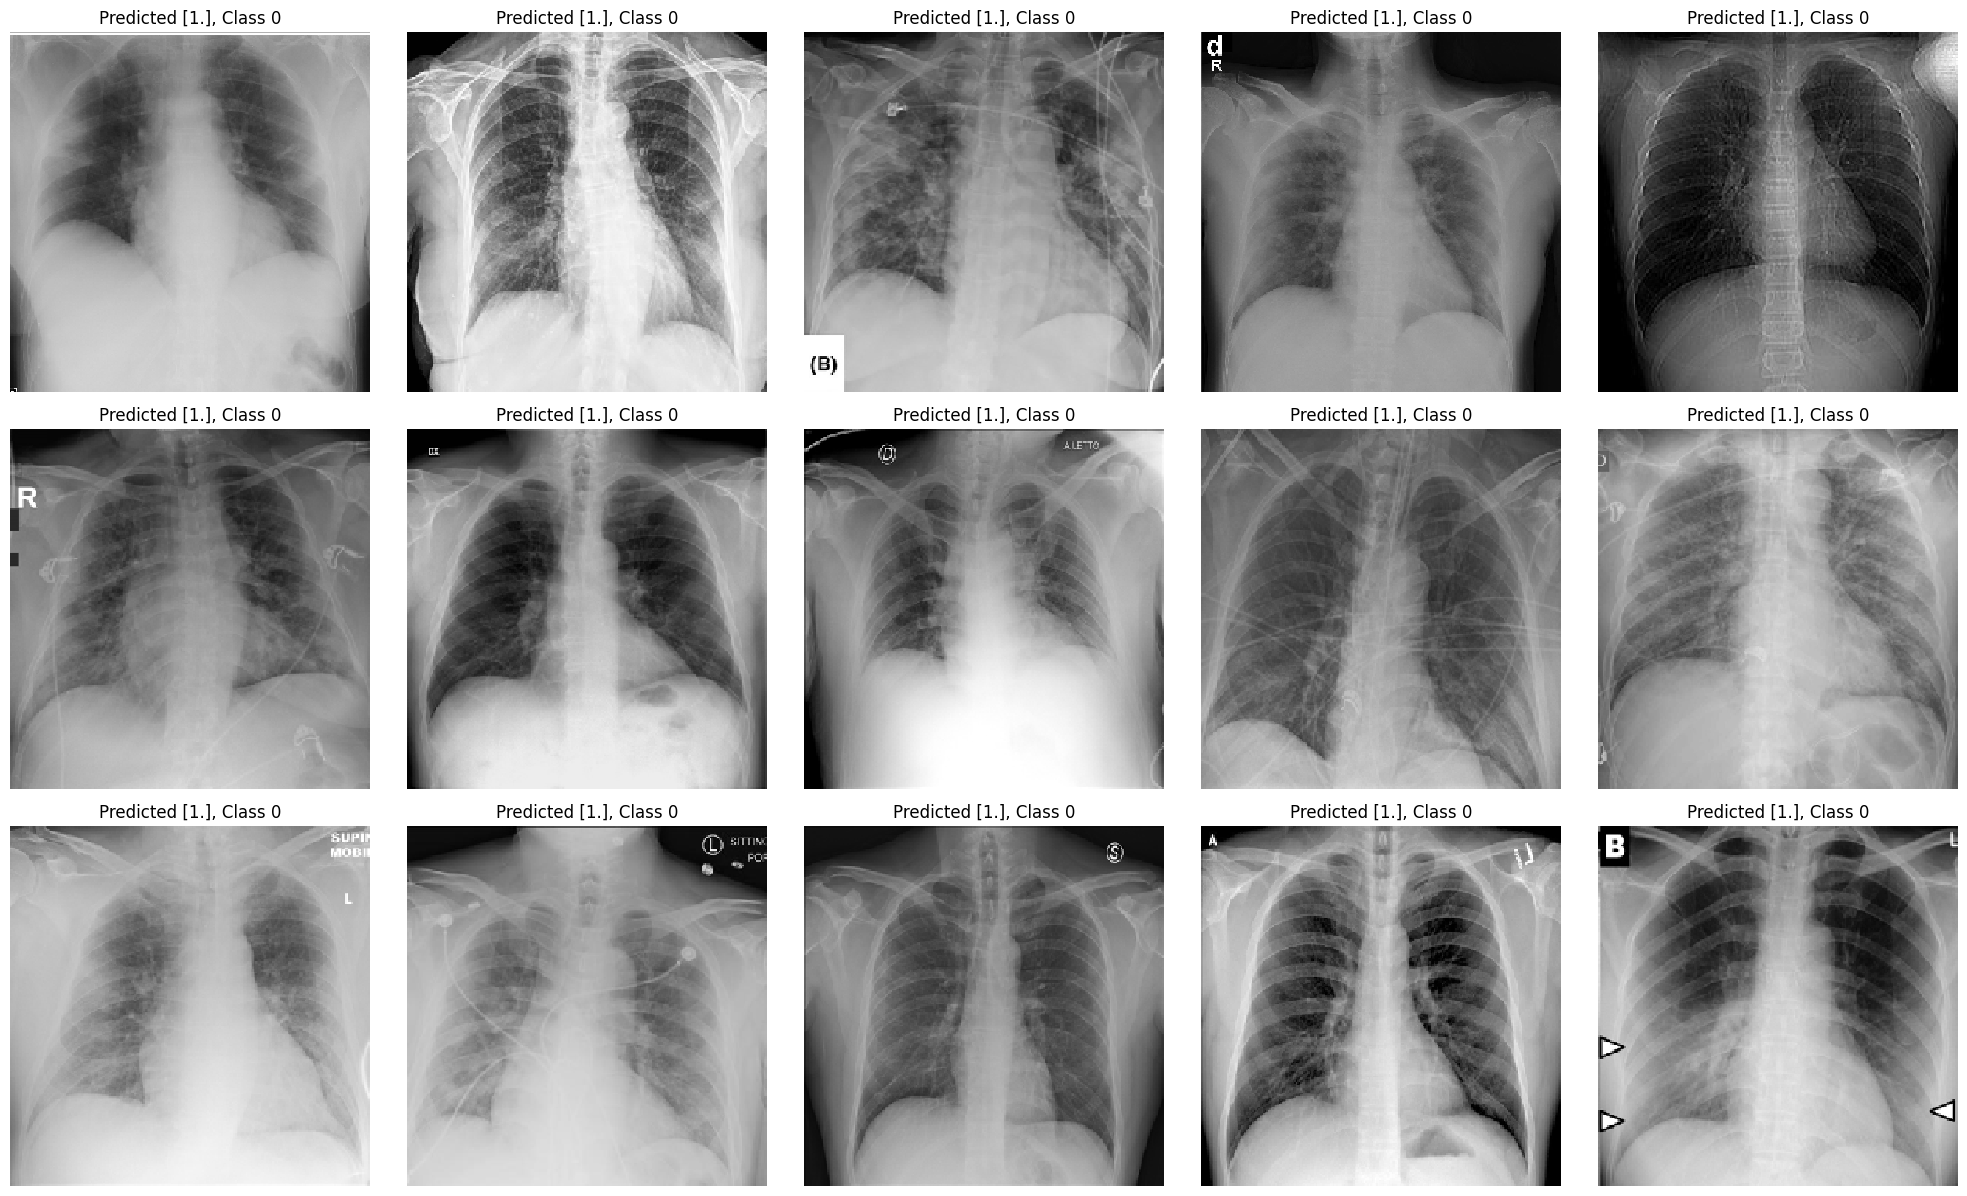

In [ ]:
plt.figure(figsize=(20, 20))
for i, incorrect in enumerate(incorrect_indices[:15]):
    image_path = test_generator.filepaths[i]
    image = plt.imread(image_path)
    plt.subplot(5, 5, i+1)
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_pred[incorrect], y_true[incorrect]))
    plt.axis("off")
    plt.tight_layout()

###Confusion Matrix

Text(50.722222222222214, 0.5, 'Actual')

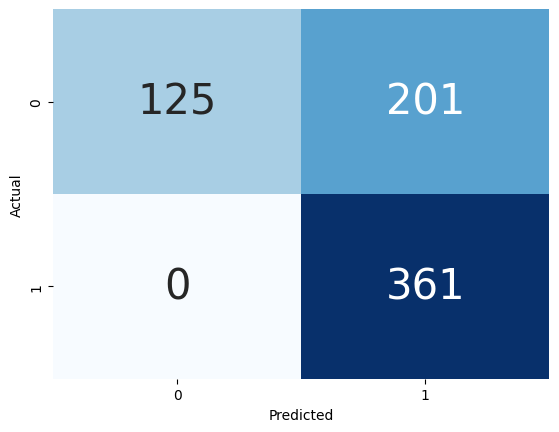

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm,
        annot=True,
        annot_kws={"size": 30},
        fmt='g',
        cbar=False,
        cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

###Predict Single Image

In [ ]:
from tensorflow.keras.preprocessing import image
def preprocess(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array, img

Predicted label: NORMAL [[0.99702346]]


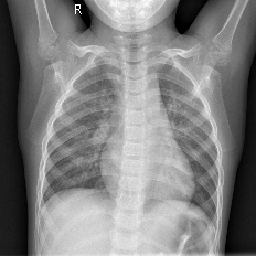

In [ ]:
img_path = '/content/drive/MyDrive/Celerates/roentgen/test/NORMAL/NORMAL_33.png'
img_array, img = preprocess(img_path, tuple(DIMENSIONS))
predictions = cnn1.predict(img_array, verbose=0)
if (predictions > 0.5).astype('int32'):
    print('Predicted label: NORMAL', predictions)
else:
    print('Predictted label: COVID', predictions)
img

##VGGNet

###Create CNN Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
def create_vgg_model(input_shape=(224, 224, 3), num_classes=1):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_vgg_model()
model.summary()


58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

###Training Model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_folder = '/content/drive/MyDrive/Celerates/dataset'

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    input_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    input_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Train model
history = model.fit(train_generator, validation_data=validation_generator, epochs=10)


Found 2744 images belonging to 2 classes.
Found 685 images belonging to 2 classes.
Epoch 1/10
86/86 [==============================] - 6943s 80s/step - loss: 0.7766 - accuracy: 0.5135 - val_loss: 0.6930 - val_accuracy: 0.5255
Epoch 2/10
86/86 [==============================] - 6748s 79s/step - loss: 0.6513 - accuracy: 0.5973 - val_loss: 0.7114 - val_accuracy: 0.7299
Epoch 3/10
86/86 [==============================] - 6712s 78s/step - loss: 0.1739 - accuracy: 0.9264 - val_loss: 0.0601 - val_accuracy: 0.9883
Epoch 4/10
86/86 [==============================] - 6741s 78s/step - loss: 0.0829 - accuracy: 0.9749 - val_loss: 0.0419 - val_accuracy: 0.9883
Epoch 5/10
86/86 [==============================] - 6730s 78s/step - loss: 0.0646 - accuracy: 0.9818 - val_loss: 0.0902 - val_accuracy: 0.9664
Epoch 6/10
58/86 [===================>..........] - ETA: 33:39 - loss: 0.0625 - accuracy: 0.9843

###Plot training and validation loss

In [ ]:
import matplotlib.pyplot as plt

output_folder = '/content/drive/MyDrive/Celerates/roentgen'

def plot_training_history(history, output_folder):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.savefig(f'{output_folder}/training_history.png')
    plt.show()

plot_training_history(history, output_folder)


NameError: name 'history' is not defined

###Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on validation data
val_pred = model.predict(validation_generator)
val_pred_binary = (val_pred > 0.5).astype(int)

# True labels
val_labels = validation_generator.classes

# Classification report
class_report = classification_report(val_labels, val_pred_binary, output_dict=True)
print(classification_report(val_labels, val_pred_binary))

# Confusion matrix
conf_matrix = confusion_matrix(val_labels, val_pred_binary)
print(conf_matrix)

# Save classification report and confusion matrix
import json

with open(f'{output_folder}/classification_report.json', 'w') as f:
    json.dump(class_report, f)

np.savetxt(f'{output_folder}/confusion_matrix.txt', conf_matrix, fmt='%d')


NameError: name 'model' is not defined

###Confusion Matrix

###Predict Single Model

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    return 'Positive' if prediction > 0.5 else 'Negative'

# Example prediction
img_path = '/path_to_individual_image.jpg'  # Ganti dengan path yang sesuai
result = predict_image(model, img_path)
print(f'The prediction for the image is: {result}')
